# NAPE Calcium Imaging Event-Related Analysis

Finds any .tif, .tiff, .h5 files in the requested directory and performs SIMA-based motion correction and fft-based bidirection 
offset correction, signal extraction, and neuropil correction. This code parallelizes the computation at the session level by passing the multiple file paths (if there are more than one recordings) to the multiprocessing map function. 


How to run this code
------------------------------------

__In this jupyter notebook, just run all cells in order (shift + enter).__

You can indicate specific files, parameters, and processing steps to include by __editing the python script called files_to_analyze_event.py__ (in the same directory as this script). Once you have specified the files in files_to_analyze.py and saved, run this notebooks' cells, leave the input blank, and press enter; this code will automatically load the information in files_to_analyze_event.py.


Required Packages
-----------------
Python 2.7, seaborn, matplotlib, pandas, scikit-learn

Custom code requirements: utils

Parameters (Only relevant if using the subfunction batch_process; ignore if using files_to_analyze or using default params by inputting a file directory)
----------

fname : string
    
    Base name of the file to analyze (pre-motion corrected file name).

fdir : string 

    Root file directory containing the raw tif, tiff, h5 files. Note: leave off the last backslash. For example: C:\Users\my_user\analyze_sessions
    
trial_start_end : list of two entries  

    Entries can be ints or floats. The first entry is the time in seconds relative to the event/ttl onset for the start of the event analysis window (negative if before the event/ttl onset. The second entry is the time in seconds for the end of the event analysis window. For example if the desired analysis window is 5.5 seconds before event onset and 8 seconds after, `trial_start_end` would be [-5.5, 8].  
    
baseline_end : int/float  

    Time in seconds for the end of the baseline epoch. By default, the baseline epoch start time will be the first entry ot `trial_start_end`. This baseline epoch is used for calculating baseline normalization metrics.
    
event_dur : int/float  

    Time in seconds representing how long the behavioral event or stimulation, etc. lasts.

flag_npil_corr : boolean  

    Set as True if user would like to load in neuropil corrected data from the preprocessing pipeline. Must have a \*\_neuropil\_corrected_signal_* file in the directory. If set as False, just use the extracted_signal file.
    
flag_zscore : boolean  

    Set as True if analyzed data should be baseline z-scored on a trial level.  

flag_sort_rois : boolean

    Set as True to sort ROIs on the y axis of heatmaps. This works with `user_sort_method` and `roi_sort_cond` for specifying details of sorting.

flag_roi_trial_avg_errbar : boolean  

    Set as True to set standard error of mean shaded portions for line plots of trial-averaged activity.   

flag_save_figs : boolean  

    Set as True to save figures as JPG and vectorized formats.  

interesting_rois : list of ints  

    All entries are indices for ROIs that will be marked in heatmaps by arrows.  

Optional Parameters (Only relevant if using batch_process)
-------------------

user_sort_method : string
    
    Takes the strings 'peak_time' or 'max_value'
    
    
roi_sort_cond : string
    for roi-resolved heatmaps, which condition to sort ROIs by
    
    Defaults to first condition available
    
Output
-------

output_images : folder containing images  
    
    You will also find a folder containing plots that reflect how each executed preprocessing step performed. Examples are mean images for motion corrected data, ROI masks overlaid on mean images, extracted signals for each ROI, etc..


In [3]:
import os
import numpy as np
import glob
import pickle
import seaborn as sns
import matplotlib.ticker as ticker
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from __future__ import division # make py2 act like py3 where int division turns into float
import matplotlib
#important for text to be detected when importing saved figures into illustrator
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42

import utils

In [4]:
# simple class to update limits as you go through iterations of data
# first call update_lims(first_lims)
# then update_lims.update(new_lims)
# update_lims.output() outputs lims
class update_lims:
    
    def __init__(self, lims):
        self.lims = lims
        
    
    def update(self, new_lims):
        if self.lims[0] > new_lims[0]:
            self.lims[0] = new_lims[0]
        
        if self.lims[1] < new_lims[1]:
            self.lims[1] = new_lims[1]

    def output(self):
        return self.lims
    
    
# find 2D subplot index based on a numerical incremented index (ie. idx=3 would be (2,1) for a 2x2 subplot figure)     
def subplot_loc(idx, num_rows, num_col):
    if n_rows == 1:
        subplot_index = idx
    else:
        subplot_index = np.unravel_index(idx_cond, (n_rows, int(n_columns))) # turn int index to a tuple of array coordinates
    return subplot_index

# declare some fixed constant variables
axis_label_size = 15

In [60]:
"""

User-defined variables

"""

def define_params(method = 'single'):
    
    fparams = {}
    
    if method == 'single':
        
        fparams['fname'] = '2020_06_17_aac10_d02_deplete-000_concat' # 'vj_ofc_imageactivate_02_200_006' # 
        fparams['fdir'] = r'D:\bruker_data\Adam\2020_06_17_aac10_d02_deplete\2020_06_17_aac10_d02_deplete-000' #  r'D:\bruker_data\vj_ofc_imageactivate_02_200\vj_ofc_imageactivate_02_200_006' #  

        fparams['fname'] = 'VJ_OFCVTA_7_260_D6'  
        fparams['fdir'] = r'C:\\2pData\\Vijay data\\VJ_OFCVTA_7_D8_trained' 
        
        # set the sampling rate
        fparams['fs'] = 30

        # trial windowing 
        fparams['trial_start_end'] = [-5.5, 8]
        fparams['baseline_end'] = -0.2
        fparams['event_dur'] = 2 # duration of stim/event in seconds

        # analysis and plotting arguments
        fparams['flag_npil_corr'] = False # declare which data to load in
        fparams['flag_zscore'] = True # whether or not to z-score data for plots
        fparams['flag_sort_rois'] = True
        if fparams['flag_sort_rois']:
            fparams['user_sort_method'] = 'max_value' # peak_time or max_value
            fparams['roi_sort_cond'] = 'plus' # for roi-resolved heatmaps, which condition to sort ROIs by
        fparams['flag_roi_trial_avg_errbar'] = True # toggle to show error bar on roi- and trial-averaged traces
        fparams['flag_trial_avg_errbar'] = True # toggle to show error bars on the trial-avg traces
        fparams['flag_save_figs'] = False
        fparams['interesting_rois'] = [ 0, 1, 2, 23, 22, 11, 9, 5, 6, 7, 3, 4, 8, 12, 14, 15, 16, 17] # [35, 30, 20, 4] #
    
    elif method == 'f2a': # if string is empty, load predefined list of files in files_to_analyze_event

        fparams = files_to_analyze_event.define_fparams()

    elif method == 'root_dir':
        
        pass
    
    return fparams

In [61]:
fparams = define_params(method = 'single') # options are 'single', 'f2a', 'root_dir'

In [46]:
if fparams['flag_npil_corr'] == True:
    signals_fpath = os.path.join(fparams['fdir'], "{}_neuropil_corrected_signals*".format(fparams['fname']))
    
else:
    signals_fpath = os.path.join(fparams['fdir'], "*_extractedsignals*")

save_dir = os.path.join(fparams['fdir'], 'event_rel_analysis_' + fparams['fname'])

utils.check_exist_dir(save_dir) # make the save directory

'C:\\\\2pData\\\\Vijay data\\\\VJ_OFCVTA_7_D8_trained\\event_rel_analysis_VJ_OFCVTA_7_260_D6'

In [47]:
trial_start_end_sec = np.array(fparams['trial_start_end']) # trial windowing in seconds relative to ttl-onset/trial-onset, in seconds
baseline_start_end_sec = np.array([trial_start_end_sec[0], fparams['baseline_end']])

# convert times to samples and get sample vector for the trial 
trial_begEnd_samp = trial_start_end_sec*fparams['fs'] # turn trial start/end times to samples
trial_svec = np.arange(trial_begEnd_samp[0], trial_begEnd_samp[1])
# and for baseline period
baseline_begEnd_samp = baseline_start_end_sec*fparams['fs']
baseline_svec = (np.arange(baseline_begEnd_samp[0], baseline_begEnd_samp[1]+1, 1) - baseline_begEnd_samp[0]).astype('int')

# calculate time vector for plot x axes
num_samples_trial = len( trial_svec )
tvec = np.round(np.linspace(trial_start_end_sec[0], trial_start_end_sec[1], num_samples_trial+1), 2)

# find samples and calculations for time 0 for plotting
t0_sample = utils.get_tvec_sample(tvec, 0) # grabs the sample index of a given time from a vector of times
event_bound_ratio = [(t0_sample-1)/num_samples_trial , (t0_sample+fparams['event_dur']*fparams['fs']+1)/num_samples_trial] # fraction of total samples for event start and end; only used for plotting line indicating event duration

In [48]:
glob_frame_files = glob.glob(os.path.join(fparams['fdir'], "framenumberforevents_{}*".format(fparams['fname']))) # look for a file in specified directory
event_frames = pickle.load( open( glob_frame_files[0], "rb" ) ) # latin1 b

In [49]:
# load time-series data
glob_signal_files = glob.glob(signals_fpath)
if len(glob_signal_files) == 1:
    signals = np.squeeze(np.load(glob_signal_files[0]))
else:
    print('Warning: No or multiple signal files detected; using first detected file')

num_rois = signals.shape[0]
    
#load behavioral data and trial info
try:
    glob_frame_files = glob.glob(os.path.join(fparams['fdir'], "framenumberforevents_{}*".format(fparams['fname']))) # look for a file in specified directory
    event_frames = pickle.load( open( glob_frame_files[0], "rb" ) ) # latin1 b/c original pickle made in python 2

except:
    print('Cannot find behavioral data file or file path is incorrect; utils.extract_trial_data will throw error.')

# identify conditions to analyze
all_conditions = event_frames.keys()
conditions = [ condition for condition in all_conditions if len(event_frames[condition]) > 0 ] # keep conditions that have events

tmp  = [ conditions[i] for i in [0, 2, 4] ] # only for vijay data - some of the conditions in his data are duplicates [0, 2, 4]
conditions = tmp
print( conditions )

['licks', 'plus', 'minus']


In [50]:
# extract trial data
data_dict = utils.extract_trial_data(signals, trial_begEnd_samp, event_frames, 
                                     conditions, baseline_start_end_samp = baseline_begEnd_samp)

In [51]:
# calculate all the color limits for heatmaps; useful for locking color limits across different heatmap subplots

# for trial_avg data, get min/max across conditions
clims_data = [ np.nanmin( [np.mean(data_dict[key]['data'], axis = 0) for key in data_dict] ), 
        np.nanmax( [np.mean(data_dict[key]['data'], axis = 0) for key in data_dict] ) ]

# for z-scored data, we'd like for the color scale to be centered at 0; first we get color limits
tmp_clim = [ np.nanmin( [data_dict[key]['ztrial_avg_data'] for key in data_dict] ), 
        np.nanmax( [data_dict[key]['ztrial_avg_data'] for key in data_dict] ) ]
# then we take the higher of the two magnitudes
clims_max = np.max(np.abs(tmp_clim))
# and set it as the negative and positive limit for plotting
clims_z = [-clims_max*0.3, clims_max*0.3]

## Plot trial-resolved heatmap for each ROI

In [52]:
def subplot_trial_heatmap(data_in, conditions, tvec, event_bound_ratio, clims, n_rows, n_columns, 
                           save_fig = False, axis_label_size=15):
    
    for idx_cond, cond in enumerate(conditions):
        
        # set imshow extent to replace x and y axis ticks/labels
        plot_extent = [tvec[0], tvec[-1], 0, data_in[cond]['num_trials']]
        
        # determine subplot location index
        subplot_index = subplot_loc(idx_cond, n_rows, n_columns)
        
        # plot x and y labels for first subplot
        if subplot_index == (0, 0) or subplot_index == 0 :
            ax[subplot_index].set_ylabel('Trial', fontsize=axis_label_size)
            ax[subplot_index].set_xlabel('Time [s]', fontsize=axis_label_size);
        
        # prep the data
        to_plot = np.squeeze(data_in[cond]['data'][...,iROI,:]) 
        if len(event_frames[cond]) == 1: # accomodates single trial data
            to_plot = to_plot[np.newaxis, :]
        
        # plot the data
        title = 'ROI {}; {}'.format(str(iROI), cond)
        im = utils.subplot_heatmap(ax[subplot_index], title, to_plot, cmap='inferno', clims=clims, extent_=plot_extent)
        
        # add meta data lines
        ax[subplot_index].axvline(0, color='0.5', alpha=1) # plot vertical line for time zero
        ax[subplot_index].annotate('', xy=(event_bound_ratio[0], -0.01), xycoords='axes fraction', 
                                   xytext=(event_bound_ratio[1], -0.01), 
                                   arrowprops=dict(arrowstyle="-", color='g'))
        
    cbar = fig.colorbar(im, ax = ax[subplot_index], shrink = 0.5)
    cbar.ax.set_ylabel('Activity')
    
#def subplot_trial_avg_trace():

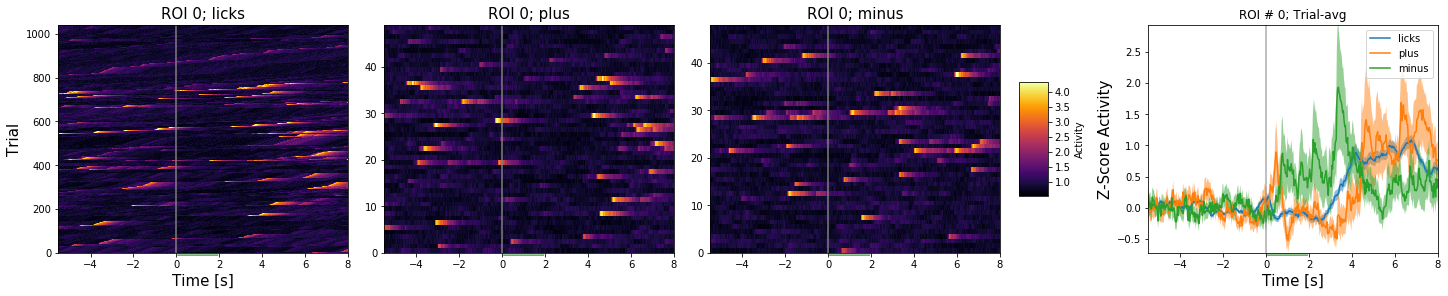

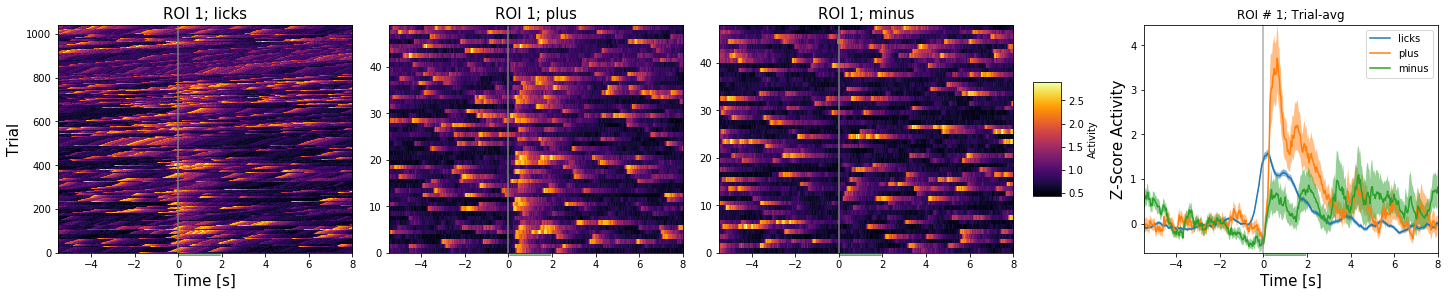

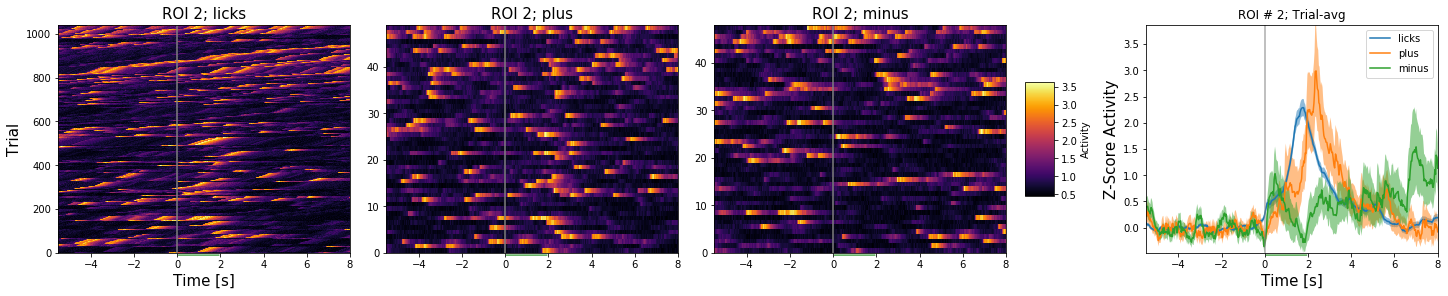

In [54]:
num_subplots = len(conditions) + 1 # plus one for trial-avg traces
n_columns = np.min([num_subplots, 4.0])
n_rows = int(np.ceil(num_subplots/n_columns))

for iROI in range(3):
 
    roi_clims = [ np.nanmin( [np.nanmin(data_dict[cond]['data'][...,iROI,:]) for cond in conditions] ), 
        np.nanmax( [np.nanmax(data_dict[cond]['data'][...,iROI,:]) for cond in conditions] ) ]
    
    fig, ax = plt.subplots(nrows=n_rows, ncols=int(n_columns), 
                           figsize = (n_columns*5, n_rows*4),
                           constrained_layout=True)
    
    subplot_trial_heatmap(data_dict, conditions, tvec, event_bound_ratio, roi_clims, n_rows, n_columns, 
                           save_fig = False)
    
    ########## plot last subplot of trial-avg traces
    
    # determine subplot location index
    subplot_index = subplot_loc(num_subplots-1, n_rows, n_columns)

    for cond in conditions:
        
        # prep data to plot
        num_trials = data_dict[cond]['num_trials']
        to_plot = np.mean(data_dict[cond]['zdata'][:,iROI,:], axis=0)
        to_plot_err = np.std(data_dict[cond]['zdata'][:,iROI,:], axis=0)/np.sqrt(num_trials)
        
        # plot trace
        ax[subplot_index].plot(tvec, to_plot)
        # plot shaded error
        if fparams['flag_trial_avg_errbar']:
            ax[subplot_index].fill_between(tvec, to_plot - to_plot_err, to_plot + to_plot_err,
                         alpha=0.5) # this plots the shaded error bar
        
    # plot x, y labels, and legend
    ax[subplot_index].set_ylabel('Z-Score Activity', fontsize=axis_label_size)
    ax[subplot_index].set_xlabel('Time [s]', fontsize=axis_label_size)
    ax[subplot_index].set_title('ROI # {}; Trial-avg'.format(str(iROI)))
    ax[subplot_index].legend(conditions)
    ax[subplot_index].autoscale(enable=True, axis='both', tight=True)
    ax[subplot_index].axvline(0, color='0.5', alpha=0.65) # plot vertical line for time zero
    ax[subplot_index].annotate('', xy=(event_bound_ratio[0], -0.01), xycoords='axes fraction', 
                                   xytext=(event_bound_ratio[1], -0.01), 
                                   arrowprops=dict(arrowstyle="-", color='g'))
    
    fig.savefig( os.path.join(save_dir,'roi_{}_activity.png'.format(str(iROI))) ); 
    fig.savefig( os.path.join(save_dir,'roi_{}_activity.pdf'.format(str(iROI))) );

In [62]:
# function to find closest sample when a time occurs in a time vector
tvec2samp = lambda tvec, time: np.argmin(np.abs(tvec - time))

# function to sort ROIs based on activity in certain epoch
def sort_heatmap_peaks(data, tvec, sort_epoch_start_time, sort_epoch_end_time, sort_method = 'peak_time'):
    
    # find start/end samples for epoch
    sort_epoch_start_samp = tvec2samp(tvec, sort_epoch_start_time)
    sort_epoch_end_samp = tvec2samp(tvec, sort_epoch_end_time)
    
    if sort_method == 'peak_time':
        epoch_peak_samp = np.argmax(data[:,sort_epoch_start_samp:sort_epoch_end_samp], axis=1)
        final_sorting = np.argsort(epoch_peak_samp)
    elif sort_method == 'max_value':
        time_max = np.max(data[:,sort_epoch_start_samp:sort_epoch_end_samp], axis=1)
        final_sorting = np.argsort(time_max)[::-1]

    return final_sorting

In [65]:
if fparams['flag_sort_rois']:
    if not fparams['roi_sort_cond']:
        fparams['roi_sort_cond'] = data_dict.keys()[0]
    # returns new order of rois sorted using the data and method supplied in the specified window
    sorted_roi_order = sort_heatmap_peaks(data_dict[fparams['roi_sort_cond']]['ztrial_avg_data'], tvec, 
                       sort_epoch_start_time=0, 
                       sort_epoch_end_time = trial_start_end_sec[-1], 
                       sort_method = fparams['user_sort_method'])
    # finds corresponding interesting roi order after sorting
    interesting_rois = np.in1d(sorted_roi_order, fparams['interesting_rois']).nonzero()[0] 

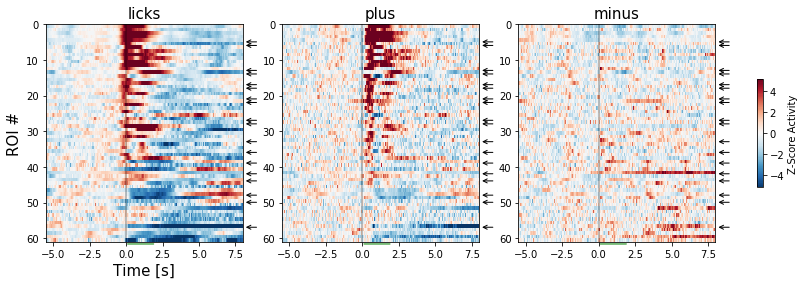

In [67]:
def plot_trial_avg_heatmap(data_in, conditions, tvec, event_bound_ratio, clims, sorted_roi_order = None, 
                           rois_oi = None, save_fig = False, axis_label_size=15):
    
    num_subplots = len(conditions)
    n_columns = np.min([num_subplots, 3.0])
    n_rows = int(np.ceil(num_subplots/n_columns))

    # set imshow extent to replace x and y axis ticks/labels (replace samples with time)
    plot_extent = [tvec[0], tvec[-1], num_rois, 0 ]

    fig, ax = plt.subplots(nrows=n_rows, ncols=int(n_columns), figsize = (n_columns*5, n_rows*4))
    if not isinstance(ax,np.ndarray): # this is here to make the code below compatible with indexing a single subplot object
        ax = [ax]

    for idx, cond in enumerate(conditions):

        # determine subplot location index
        if n_rows == 1:
            subplot_index = idx
        else:
            subplot_index = np.unravel_index(idx, (n_rows, int(n_columns))) # turn int index to a tuple of array coordinates

        # plot x and y labels for first subplot
        if subplot_index == (0, 0) or subplot_index == 0 :
            ax[subplot_index].set_ylabel('ROI #', fontsize=axis_label_size)
            ax[subplot_index].set_xlabel('Time [s]', fontsize=axis_label_size);

        # plot the data
        if sorted_roi_order is not None:
            roi_order = sorted_roi_order
        else:
            roi_order = slice(0, num_rois)
        to_plot = data_in[cond]['ztrial_avg_data'][roi_order,:] # np.mean( data_dict[cond]['data'], axis=0) #

        im = utils.subplot_heatmap(ax[subplot_index], cond, to_plot, clims = clims, extent_=plot_extent)
        ax[subplot_index].axvline(0, color='k', alpha=0.3) # plot vertical line for time zero
        ax[subplot_index].annotate('', xy=(event_bound_ratio[0], -0.01), xycoords='axes fraction', 
                                       xytext=(event_bound_ratio[1], -0.01), 
                                       arrowprops=dict(arrowstyle="-", color='g'))
        if rois_oi is not None:
            for ROI_OI in rois_oi:
                ax[subplot_index].annotate('', xy=(1.005, 1-(ROI_OI/num_rois)-0.015), xycoords='axes fraction', 
                                           xytext=(1.08, 1-(ROI_OI/num_rois)-0.015), 
                                           arrowprops=dict(arrowstyle="->", color='k'))

    cbar = fig.colorbar(im, ax = ax, shrink = 0.5)
    cbar.ax.set_ylabel('Z-Score Activity')
    
    if save_fig is True:
        fig.savefig(os.path.join(save_dir,'trial_avg_heatmap.png')); fig.savefig(os.path.join(save_dir,'trial_avg_heatmap.pdf'));
    
plot_trial_avg_heatmap(data_dict, conditions, tvec, event_bound_ratio, clims = clims_z,
                       sorted_roi_order = sorted_roi_order, rois_oi = interesting_rois, save_fig = fparams['flag_save_figs'])    

## Plot trial- and ROI-averaged traces

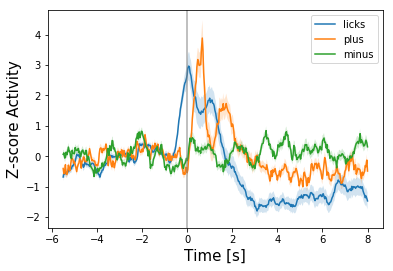

In [69]:
for cond in conditions:
    # first trial avg the data
    trial_avg = np.mean(data_dict[cond]['data'], axis=0)
    
    # z-score trial-avg data for each respective ROI
    # apply zscore function to each row of data
    app_axis = 1 
    zscore_trial_avg = np.apply_along_axis(utils.zscore_, app_axis, trial_avg, baseline_svec)
    
    # take avg/std across ROIs
    zscore_roi_trial_avg = np.mean(zscore_trial_avg, axis=0)
    zscore_roi_trial_std = np.std(zscore_trial_avg, axis=0)
     
    to_plot = np.squeeze(zscore_roi_trial_avg)
    to_plot_err = np.squeeze(zscore_roi_trial_std)/np.sqrt(num_rois)
    
    fig = sns.lineplot(tvec, to_plot)
    if fparams['flag_roi_trial_avg_errbar']:
        fig.fill_between(tvec, to_plot - to_plot_err, to_plot + to_plot_err,
                     alpha=0.2) # this plots the shaded error bar
    
fig.set_ylabel('Z-score Activity', fontsize=axis_label_size)
fig.set_xlabel('Time [s]', fontsize=axis_label_size);
fig.legend(conditions);
fig.axvline(0, color='0.5', alpha=0.65) # plot vertical line for time zero

In [ ]:
# # for saving behav data

# import numpy as np
# import pickle
# event_frames = {}
# event_frames['slm_stim'] = np.array([254.])

# with open(r'D:\20200410_gcamp_chrmine\vj_ofc_imageactivate_01_300_stim-009\framenumberforevents_vj_ofc_imageactivate_01_300_stim-009.pickle', 'wb') as handle:
#     pickle.dump(event_frames, handle, protocol=pickle.HIGHEST_PROTOCOL)